In [1]:
import requests
import pandas as pd
import time
from tqdm import tqdm
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import kagglehub
import os

c:\users\amalf\code\python\environments\imdbenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title
API_KEY = "API KEY"

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amalf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amalf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amalf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def get_tmdb_id(imdb_id):
    url = f"https://api.themoviedb.org/3/find/{imdb_id}"
    params = {"api_key": API_KEY, "external_source": "imdb_id"}
    r = requests.get(url, params=params).json()
    return r["movie_results"][0]["id"] if r["movie_results"] else None

def get_metadata(tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}"
    params = {"api_key": API_KEY}
    r = requests.get(url, params=params).json()
    return {
        "tmdb_id": tmdb_id,
        "title": r.get("title"),
        "release_date": r.get("release_date"),
        "budget": r.get("budget"),
        "revenue": r.get("revenue"),
        "genres": ", ".join([g["name"] for g in r.get("genres", [])]),
        "vote_average": r.get("vote_average"),
        "vote_count": r.get("vote_count"),
        "runtime": r.get("runtime")
    }

def get_reviews(tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}/reviews"
    params = {"api_key": API_KEY}
    r = requests.get(url, params=params).json()
    return [rev["content"] for rev in r.get("results", [])]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    tokens = nltk.word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(w) for w in tokens if w not in stop_words])

In [5]:
best_path = kagglehub.dataset_download("octopusteam/imdb-top-1000-movies")
worst_path = kagglehub.dataset_download("octopusteam/imdb-top-1000-worst-rated-titles")

In [6]:
df_best = pd.read_csv(os.path.join(best_path, "data.csv"))
df_worst = pd.read_csv(os.path.join(worst_path, "data.csv"))
df_movies = pd.concat([df_best, df_worst], axis=0)
df_movies = df_movies[df_movies["id"].notnull()]
imdb_ids = df_movies["id"].unique().tolist()

In [7]:
movies = []
for imdb_id in tqdm(imdb_ids):
    try:
        tmdb_id = get_tmdb_id(imdb_id)
        if not tmdb_id:
            continue
        metadata = get_metadata(tmdb_id)
        reviews = get_reviews(tmdb_id)
        if not reviews or not metadata["genres"] or metadata["budget"] in [0, None]:
            continue
        metadata["imdb_id"] = imdb_id
        metadata["reviews"] = reviews
        movies.append(metadata)
        time.sleep(0.2)
    except Exception as e:
        print(f"Error for {imdb_id}: {e}")

df = pd.DataFrame(movies)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:10<00:00,  4.64it/s]


In [8]:
df.to_json("movies.json", orient="records", lines=True)

In [9]:
df = pd.read_json("movies.json", lines=True)

In [10]:
df.head()

,tmdb_id,title,release_date,budget,revenue,genres,vote_average,vote_count,runtime,imdb_id,reviews
0,278,The Shawshank Redemption,1994-09-23,25000000,28341469,"Drama, Crime",8.710,28255,142,tt0111161,"[very good movie 9.5/10 محمد الشعراوى, Some bi..."
1,238,The Godfather,1972-03-14,6000000,245066411,"Drama, Crime",8.687,21415,175,tt0068646,[The Godfather Review by Al Carlson\r\n\r\nThe...
2,84092,Ramayana: The Legend of Prince Rama,1993-01-10,5234266,0,"Animation, Fantasy, Adventure, History",8.400,43,135,tt0259534,[The evil king Ravana has his heart set on the...
3,155,The Dark Knight,2008-07-16,185000000,1004558444,"Drama, Action, Crime, Thriller",8.520,33806,152,tt0468569,[Excellent movie. Best of the trilogy. Lovely ...
4,122,The Lord of the Rings: The Return of the King,2003-12-17,94000000,1118888979,"Adventure, Fantasy, Action",8.483,25040,201,tt0167260,[And so all good things come to an end. For th...


In [11]:
print(df.shape)

(844, 11)


In [12]:
records = []
for _, row in df.iterrows():
    for review in row["reviews"]:
        records.append({
            "imdb_id": row["imdb_id"],
            "title": row["title"],
            "genre": row["genres"],
            "budget": row["budget"],
            "revenue": row["revenue"],
            "release_date": row["release_date"],
            "review": review
        })

reviews_df = pd.DataFrame(records)

In [13]:
reviews_df.head()

,imdb_id,title,genre,budget,revenue,release_date,review
0,tt0111161,The Shawshank Redemption,"Drama, Crime",25000000,28341469,1994-09-23,very good movie 9.5/10 محمد الشعراوى
1,tt0111161,The Shawshank Redemption,"Drama, Crime",25000000,28341469,1994-09-23,Some birds aren't meant to be caged.\r\n\r\nTh...
2,tt0111161,The Shawshank Redemption,"Drama, Crime",25000000,28341469,1994-09-23,Make way for the best film ever made people. *...
3,tt0111161,The Shawshank Redemption,"Drama, Crime",25000000,28341469,1994-09-23,There is a reason why this movie is at the top...
4,tt0111161,The Shawshank Redemption,"Drama, Crime",25000000,28341469,1994-09-23,It's still puzzling to me why this movie exact...


In [14]:
print(reviews_df.shape)

(2921, 7)


In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
reviews_df["cleaned_review"] = reviews_df["review"].apply(clean_text)

In [37]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(reviews_df["cleaned_review"])
sentiment_pipeline = pipeline("sentiment-analysis", truncation=True, model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")
def get_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]
    return pd.Series([result["label"], result["score"]])
reviews_df[["sentiment", "confidence"]] = reviews_df["review"].apply(get_sentiment)

Text(0.5, 1.0, 'Sentiment Distribution Across KMeans Clusters')

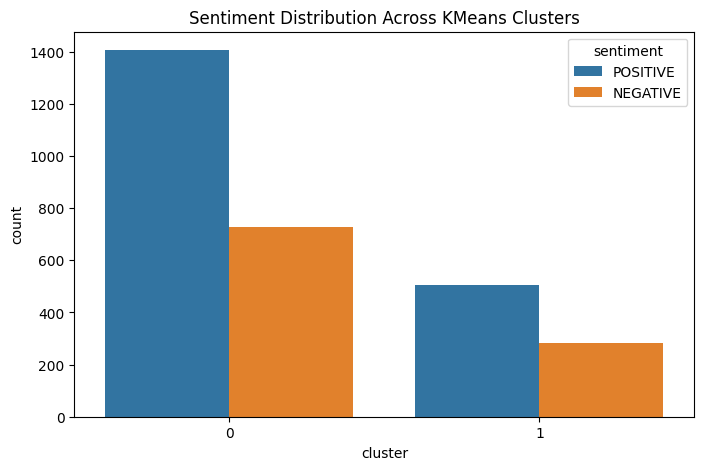

In [38]:
reviews_df["sentiment_label"] = reviews_df["sentiment"].map({"POSITIVE": 1, "NEGATIVE": 0})
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
reviews_df["cluster"] = kmeans.fit_predict(X)
plt.figure(figsize=(8, 5))
sns.countplot(data=reviews_df, x="cluster", hue="sentiment")
plt.title("Sentiment Distribution Across KMeans Clusters")

In [39]:
reviews_df["budget_group"] = pd.cut(
    reviews_df["budget"],
    bins=[0, 10_000_000, 50_000_000, 200_000_000, float("inf")],
    labels=["Low", "Medium", "High", "Blockbuster"]
)

In [40]:
genre_reviews_df = reviews_df.copy()
genre_reviews_df["genre"] = genre_reviews_df["genre"].str.split(",\s*")
genre_reviews_df = genre_reviews_df.explode("genre")

In [41]:
avg_sentiment = genre_reviews_df.groupby(["genre", "budget_group"])["sentiment_label"].mean().reset_index()
avg_sentiment.columns = ["genre", "budget_group", "avg_positive_sentiment"]
counts = genre_reviews_df.groupby(["genre", "budget_group"]).size().reset_index(name="count")
genre_budget_summary = pd.merge(avg_sentiment, counts, on=["genre", "budget_group"])
genre_budget_summary = genre_budget_summary[genre_budget_summary["count"] > 0]
genre_budget_summary.to_csv("genre_budget_sentiment_summary.csv", index=False)

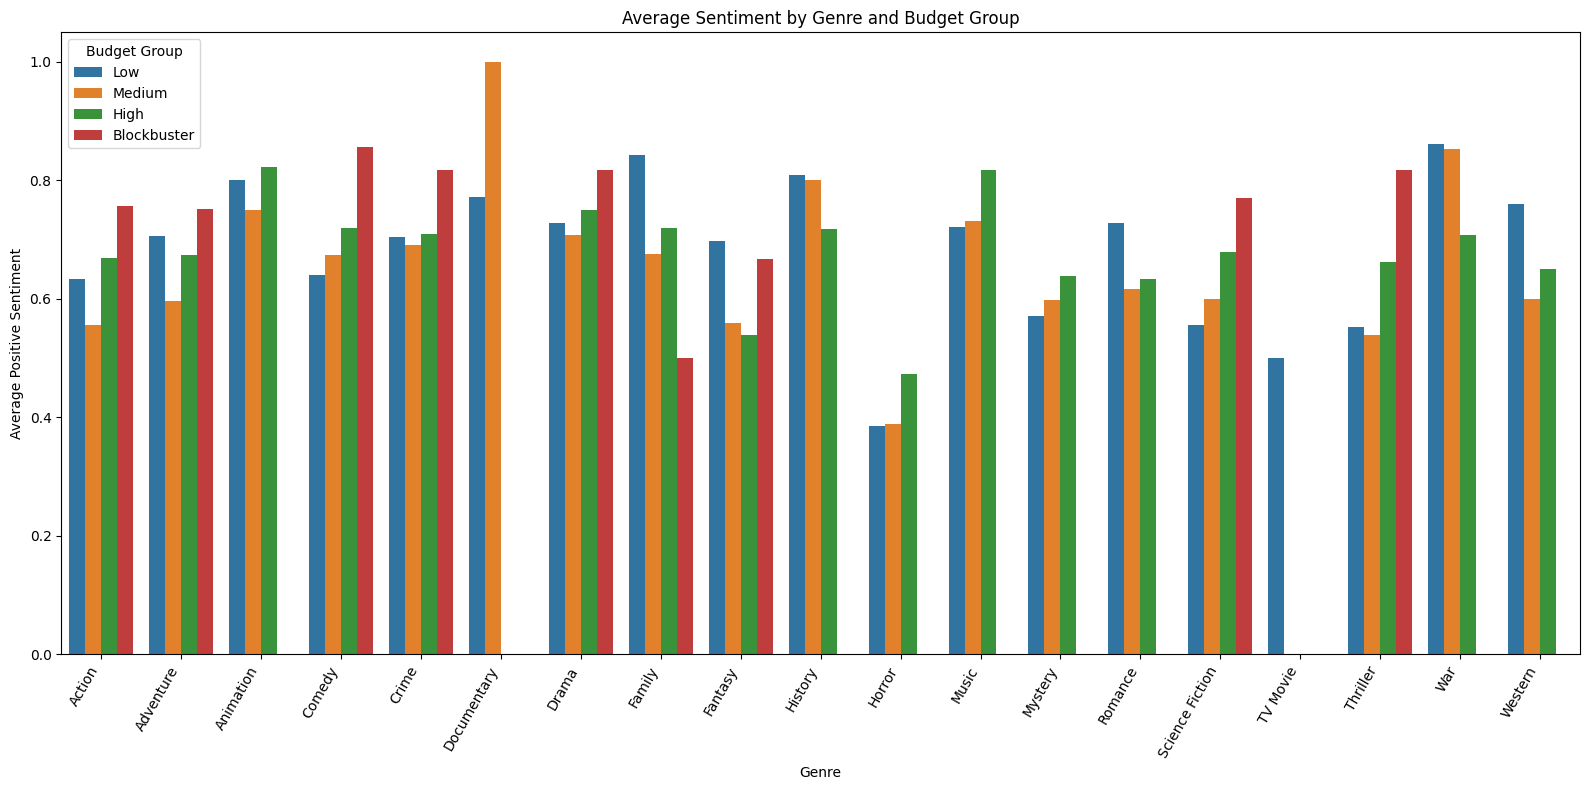

In [42]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(
    data=genre_budget_summary,
    x="genre",
    y="avg_positive_sentiment",
    hue="budget_group"
)
plt.xticks(rotation=60, ha='right')
plt.ylabel("Average Positive Sentiment")
plt.xlabel("Genre")
plt.title("Average Sentiment by Genre and Budget Group")
ax.set_ylim(bottom=0)
ax.legend(title="Budget Group")
plt.tight_layout()
plt.show()

In [43]:
avg_sentiment = genre_reviews_df.groupby(["genre"])["sentiment_label"].mean().reset_index()
avg_sentiment.columns = ["genre", "avg_positive_sentiment"]
counts = genre_reviews_df.groupby(["genre"]).size().reset_index(name="count")
genre_summary = pd.merge(avg_sentiment, counts, on=["genre"])
genre_summary = genre_summary[genre_summary["count"] > 0]
genre_summary.to_csv("genre_sentiment_summary.csv", index=False)

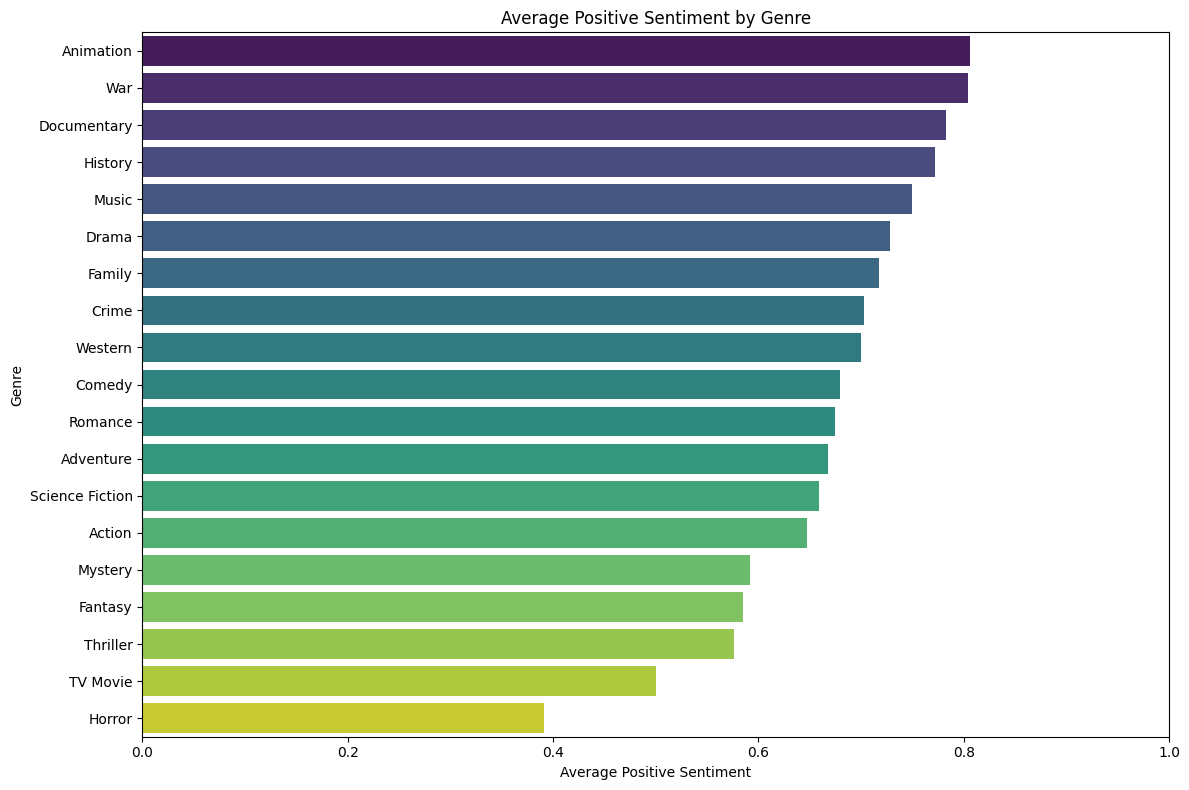

In [44]:
summary_sorted = genre_summary.sort_values("avg_positive_sentiment", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=summary_sorted,
    x="avg_positive_sentiment",
    y="genre",
    palette="viridis",
    hue="genre"
)
plt.xlabel("Average Positive Sentiment")
plt.ylabel("Genre")
plt.title("Average Positive Sentiment by Genre")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [45]:
avg_sentiment = reviews_df.groupby(["budget_group"])["sentiment_label"].mean().reset_index()
avg_sentiment.columns = ["budget_group", "avg_positive_sentiment"]
counts = reviews_df.groupby(["budget_group"]).size().reset_index(name="count")
budget_summary = pd.merge(avg_sentiment, counts, on=["budget_group"])
budget_summary = budget_summary[budget_summary["count"] > 0]
budget_summary.to_csv("budget_sentiment_summary.csv", index=False)

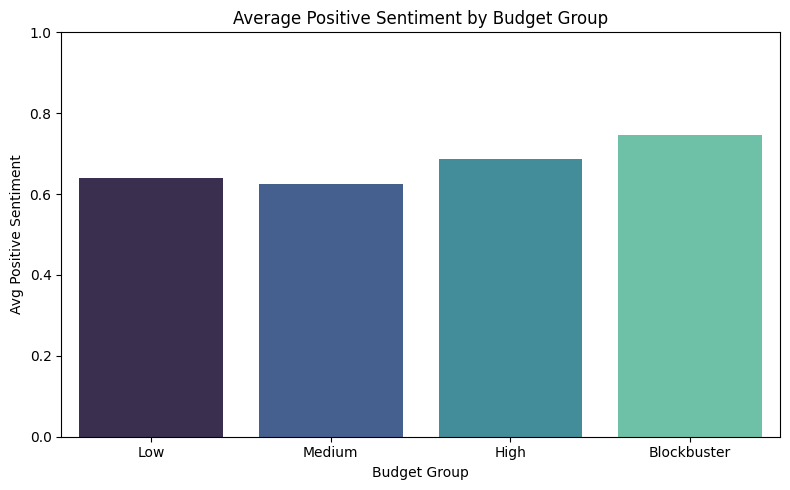

In [46]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=budget_summary,
    x="budget_group",
    y="avg_positive_sentiment",
    palette="mako",
    hue="budget_group"
)
plt.title("Average Positive Sentiment by Budget Group")
plt.ylabel("Avg Positive Sentiment")
plt.xlabel("Budget Group")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()